<a href="https://colab.research.google.com/github/LeoVogiatzis/medical_data_analysis/blob/main/Stream_based_sampling_AL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
In this example the use of ActiveLearner is demonstrated in a stream-based sampling setting.
"""

!pip install modAL

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner
from modAL.uncertainty import classifier_uncertainty

In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os#Walking through directores

import plotly.graph_objects as go # Generate Graphs
from plotly.subplots import make_subplots #To Create Subplots

from sklearn import decomposition #pca
from sklearn.preprocessing import StandardScaler # Standardization ((X - X_mean)/X_std)

pd.set_option('display.max_columns', None)#Setting Max Columns Display to Max inorder to get glance of all features in dataframe

from google.colab import files
uploaded = files.upload()

Saving cardio_train.csv to cardio_train (9).csv


In [3]:
import io

missing_values = ['?', '--', ' ', 'NA', 'N/A', '-'] #Sometimes Missing Values are't in form of NaN
df = pd.read_csv(io.BytesIO(uploaded['cardio_train.csv']),sep=';') 
print('There are Total {} datapoints in the dataset with {} Features listed as {}:'.format(df.shape[0], df.shape[1], df.columns.values))

df

There are Total 70000 datapoints in the dataset with 13 Features listed as ['id' 'age' 'gender' 'height' 'weight' 'ap_hi' 'ap_lo' 'cholesterol'
 'gluc' 'smoke' 'alco' 'active' 'cardio']:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [4]:
df.drop(columns=['id'], inplace=True)

In [5]:
duplicate_sum = df.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')


df.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(df.shape[0], df.shape[1]))

Duplicates Rows in Dataset are : 24
Total 69976 datapoints remaining with 12 features


In [6]:
def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #That's we were talking about above
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()  
        print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))
outliers(df[['height', 'weight']])

For the feature height, No of Outliers is 519
For the feature weight, No of Outliers is 1819


In [7]:
outline_free_df = df.copy()
outline_free_df[['height', 'weight']] = np.log(outline_free_df[['height', 'weight']])
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 484
For the feature weight, No of Outliers is 1174


In [8]:
outline_free_df = outline_free_df[(outline_free_df['weight'] > outline_free_df['weight'].quantile(0.005)) & (outline_free_df['weight'] < outline_free_df['weight'].quantile(0.995))]
outline_free_df = outline_free_df[(outline_free_df['height'] > outline_free_df['height'].quantile(0.005)) & (outline_free_df['height'] < outline_free_df['height'].quantile(0.995))]
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 0
For the feature weight, No of Outliers is 349


In [9]:
outline_free_df = outline_free_df[outline_free_df['ap_lo']>=0]
outline_free_df = outline_free_df[outline_free_df['ap_hi']>=0]

In [10]:
cleaned_data = outline_free_df[outline_free_df['ap_hi'] >= outline_free_df['ap_lo']].reset_index(drop=True)
print('Total observations preserved : {}'.format(len(cleaned_data)))

Total observations preserved : 67156


In [11]:
cleaned_data = cleaned_data[(cleaned_data["ap_hi"]<=250) & (cleaned_data["ap_lo"]<=200)]
print('Total {} datapoints remaining with {} features'.format(cleaned_data.shape[0], cleaned_data.shape[1]))

Total 67118 datapoints remaining with 12 features


In [12]:
cleaned_data['age'] = cleaned_data['age'].div(365).apply(lambda x: int(x))

In [13]:
cleaned_data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,5.123964,4.127134,110,80,1,1,0,0,1,0
1,55,1,5.049856,4.442651,140,90,3,1,0,0,1,1
2,51,1,5.105945,4.158883,130,70,3,1,0,0,0,1
3,48,2,5.129899,4.406719,150,100,1,1,0,0,1,1
4,47,1,5.049856,4.025352,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
67151,57,1,5.105945,4.382027,150,80,1,1,0,0,1,1
67152,52,2,5.123964,4.330733,120,80,1,1,1,0,1,0
67153,52,2,5.209486,4.653960,180,90,3,1,0,1,0,1
67154,61,1,5.093750,4.276666,135,80,1,2,0,0,0,1


In [14]:
duplicate_sum = cleaned_data.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Duplicates Rows in Dataset are : 3180


In [15]:
cleaned_data.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(cleaned_data.shape[0], df.shape[1]))

Total 63938 datapoints remaining with 12 features


In [16]:
target_value = cleaned_data['cardio']
cleaned_data_for_pca = cleaned_data.drop(['cardio'], axis=1)

In [17]:
scaled_data = StandardScaler().fit_transform(cleaned_data_for_pca)

pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(scaled_data)

pca_data = np.vstack((pca_data.T, target_value)).T
pca_df = pd.DataFrame(data = pca_data, columns = ('first', 'second', 'label'))

In [18]:
X = cleaned_data.drop(['cardio'], axis =1)
y = cleaned_data['cardio']

In [19]:
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner



X = X.to_numpy()
y = y.to_numpy()

# assembling initial training set
n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_train, y_train = X[initial_idx], y[initial_idx]

# initialize the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_train, y_training=y_train
)
unqueried_score = learner.score(X, y)

print('Initial prediction accuracy: %f' % unqueried_score)

Initial prediction accuracy: 0.512184


In [20]:
from modAL.uncertainty import classifier_uncertainty

performance_history = [unqueried_score]

# learning until the accuracy reaches a given threshold
while learner.score(X,y) < 0.70:
    stream_idx = np.random.choice(range(len(X)))
    if classifier_uncertainty(learner, X[stream_idx].reshape(1, -1)) >= 0.4:
        learner.teach(X[stream_idx].reshape(1, -1), y[stream_idx].reshape(-1, ))
        new_score = learner.score(X,y)
        performance_history.append(new_score)
        print('Query no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Query no. 16098 queried, new accuracy: 0.590510
Query no. 50029 queried, new accuracy: 0.608308
Query no. 52124 queried, new accuracy: 0.609982
Query no. 55779 queried, new accuracy: 0.596093
Query no. 21041 queried, new accuracy: 0.595217
Query no. 20192 queried, new accuracy: 0.596594
Query no. 62144 queried, new accuracy: 0.594201
Query no. 24437 queried, new accuracy: 0.586334
Query no. 20600 queried, new accuracy: 0.582627
Query no. 33490 queried, new accuracy: 0.571835
Query no. 42647 queried, new accuracy: 0.582345
Query no. 7637 queried, new accuracy: 0.591604
Query no. 46611 queried, new accuracy: 0.592949
Query no. 5971 queried, new accuracy: 0.596453
Query no. 57486 queried, new accuracy: 0.595123
Query no. 59935 queried, new accuracy: 0.596296
Query no. 35728 queried, new accuracy: 0.594529
Query no. 19382 queried, new accuracy: 0.596875
Query no. 40085 queried, new accuracy: 0.627154
Query no. 11738 queried, new accuracy: 0.631612
Query no. 28547 queried, new accuracy: 0.6

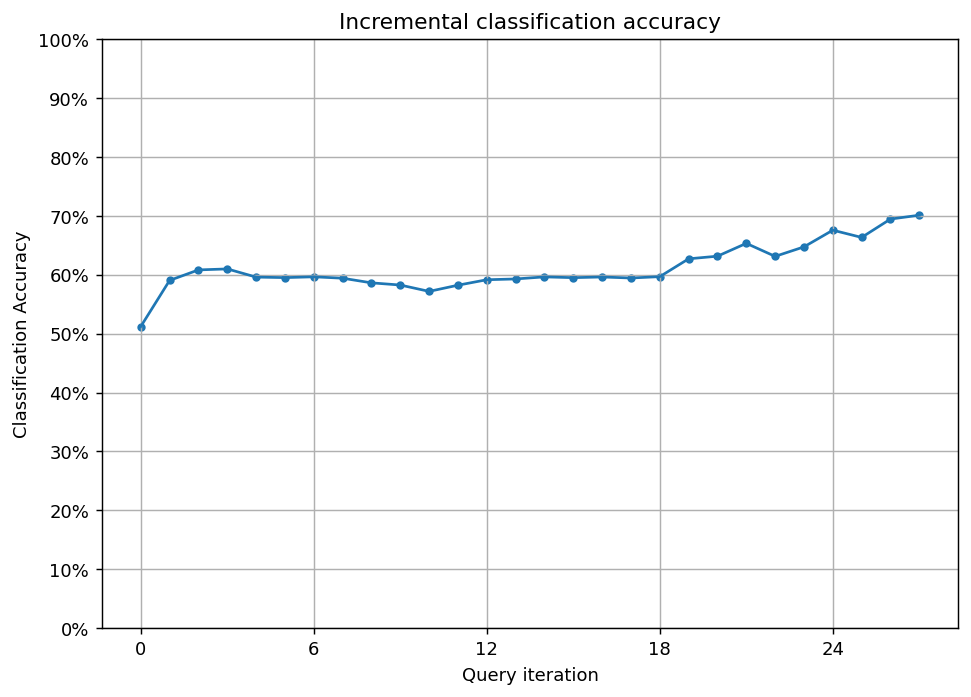

In [21]:
# Plot our performance over time.

import matplotlib as mpl
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()